# webscraping

# Play-by-Play data

## Acquire data

In [1]:
import pandas as pd
import requests, bs4, re
from bs4 import BeautifulSoup as bs

### Get links of play-by-play pages of all games of a season

In [143]:
url = 'https://www.basketball-reference.com/leagues/NBA_2009_games.html'
response = requests.get(url)
status = response.status_code
if status == 200:
  page = response.text
  soup = bs(page)
else:
  print(f"Oops! Received status code {status}")

In [144]:
monthdiv=soup.find('div', class_='filter')

In [150]:
months=monthdiv.find_all('a')

In [155]:
monthlinks=[]
for month in months:
    link='https://www.basketball-reference.com/'+month['href']
    monthlinks.append(link)

monthlinks

['https://www.basketball-reference.com//leagues/NBA_2009_games-october.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-november.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-december.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-january.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-february.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-march.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-april.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-may.html',
 'https://www.basketball-reference.com//leagues/NBA_2009_games-june.html']

In [168]:
gamelinks=[]
for link in monthlinks:
    
    url = link
    response = requests.get(url)
    status = response.status_code
    if status == 200:
      page = response.text
      soup = bs(page)
    else:
      print(f"Oops! Received status code {status}")
    
    table=soup.find('table', id='schedule')
    games=table.find_all('a', href=True, text='Box Score')
    for game in games:
        link='https://www.basketball-reference.com/boxscores/pbp/'+game['href'][11:]
        gamelinks.append(link)

In [170]:
#looks like the links contain both regular season and playoff
len(gamelinks)

1315

### Get stats from every game of the season

In [119]:
#defining function to flatten scraped data


#each final row: awaylayupattmp, awaylongtwoattmpt, awaythreeattmp, awaydistance, awaymake, awayassist, awayft, awaydr, awayor
#                 homelayupattmp, homelongtwoattmp, homethreeattmp, homedistance, homemake, homeassist, homeft, homedr, homeor
def flatten(trs):
    rows = []
    index=[1,5]
    myregex = re.compile('(\d+) ft')

    for tr in trs[3:]:

        tds=tr.find_all('td')
        row = [td.text for td in tds]
        if len(row) != 6:
            continue
        slicedrow=[row[i] for i in index]

        finalrow={'awaylayupattmp':0, 'awaylongtwoattmp':0, 'awaythreeattmp':0, 'awaydistance':0, 'awaymake':0, 'awayassist':0, 'awayft':0, 'awaydr':0, 'awayor':0, 
              'homelayupattmp':0, 'homelongtwoattmp':0, 'homethreeattmp':0, 'homedistance':0, 'homemake':0, 'homeassist':0, 'homeft':0, 'homedr':0, 'homeor':0}


        #away team fg
        if '-pt ' in slicedrow[0]:
            if ' ft' in slicedrow[0]:
                finalrow['awaydistance']=myregex.findall(slicedrow[0])[0]
            if ' rim' in slicedrow[0]:
                finalrow['awaydistance']=0
            if " makes " in slicedrow[0]:
                finalrow['awaymake']=1
                if 'assist ' in slicedrow[0]:
                    finalrow['awayassist']=1
            if (' 2-pt layup ' in slicedrow[0]) or (' 2-pt dunk ' in slicedrow[0]):
                finalrow['awaylayupattmp']=1
            if (' 2-pt ' in slicedrow[0]) and (' shot ' in slicedrow[0]):
                finalrow['awaylongtwoattmp']=1
            if (' 3-pt ' in slicedrow[0]):
                finalrow['awaythreeattmp']=1

        #away team ft
        elif ' free throw ' in slicedrow[0]:
            finalrow['awayft']=1
            if " makes " in slicedrow[0]:
                finalrow['awaymake']=1

        #away team rebound (not counting team rebound)
        elif ('Defensive rebound ' in slicedrow[0]) and (' by Team' not in slicedrow[0]):
            finalrow['awaydr']=1
        elif ("Offensive rebound " in slicedrow[0]) and (' by Team' not in slicedrow[0]):
            finalrow['awayor']=1    

        #home team fg
        elif '-pt ' in slicedrow[1]:
            if ' ft' in slicedrow[1]:
                finalrow['homedistance']=myregex.findall(slicedrow[1])[0]
            if ' rim' in slicedrow[1]:
                finalrow['homedistance']=0
            if " makes " in slicedrow[1]:
                finalrow['homemake']=1
                if 'assist ' in slicedrow[1]:
                    finalrow['homeassist']=1
            if (' 2-pt layup ' in slicedrow[1]) or (' 2-pt dunk ' in slicedrow[1]):
                finalrow['homelayupattmp']=1
            if (' 2-pt ' in slicedrow[1]) and (' shot ' in slicedrow[1]):
                finalrow['homelongtwoattmp']=1
            if (' 3-pt ' in slicedrow[1]):
                finalrow['homethreeattmp']=1                    

        #home team ft
        elif ' free throw ' in slicedrow[1]:
            finalrow['homeft']=1
            if " makes " in slicedrow[1]:
                finalrow['homemake']=1            

        #home team rebound (not counting team rebound)
        elif ('Defensive rebound ' in slicedrow[1]) and (' by Team' not in slicedrow[1]):
            finalrow['homedr']=1
        elif ("Offensive rebound " in slicedrow[1]) and (' by Team' not in slicedrow[1]):
            finalrow['homeor']=1                



        else:
            continue
        #print(True)
        rows.append(finalrow)
    return rows

In [ ]:
#begin scraping through the season
for url in gamelinks:
    response = requests.get(url)
    status = response.status_code
    if status == 200:
      page = response.text
      soup = bs(page)
    else:
      print(f"Oops! Received status code {status}")
    
    table=soup.find('table', id='pbp')
    trs=table.find_all('tr')
    row=flatten(trs)
    
    pass

In [2]:
url = 'https://www.basketball-reference.com/boxscores/pbp/202012230DEN.html'
response = requests.get(url)
status = response.status_code
if status == 200:
  page = response.text
  soup = bs(page)
else:
  print(f"Oops! Received status code {status}")

In [3]:
page[:100]

'\n<!DOCTYPE html>\n<html data-version="klecko-" data-root="/home/bbr/build" itemscope itemtype="https:'

In [4]:
table=soup.find('table', id='pbp')

In [5]:
trs=table.find_all('tr')

In [123]:
df = pd.DataFrame(rows)

In [140]:
df.head()

,awaylayupattmp,awaylongtwoattmp,awaythreeattmp,awaydistance,awaymake,awayassist,awayft,awaydr,awayor,homelayupattmp,homelongtwoattmp,homethreeattmp,homedistance,homemake,homeassist,homeft,homedr,homeor
0,0,0,0,0,0,0,0,0,0,0,0,1,26,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,1,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [142]:
#number of made 3s of the home team
df[(df['homethreeattmp']==1) & (df['homemake']==1)].shape[0]

8

In [128]:
df['homeor'].sum()

10

In [156]:
href="/boxscores/200810280BOS.html"

In [157]:
href[11:]

'200810280BOS.html'

# Team season average data

## Acquire data

In [1]:
import pandas as pd
import requests, bs4, re
from bs4 import BeautifulSoup as bs
import numpy as np

## Get links of 10 seasons

In [2]:
seasonlinks=[]
for i in range(2002,2022):
    link='https://www.basketball-reference.com/leagues/NBA_'+str(i)+'.html'
    seasonlinks.append(link)
seasonlinks

['https://www.basketball-reference.com/leagues/NBA_2002.html',
 'https://www.basketball-reference.com/leagues/NBA_2003.html',
 'https://www.basketball-reference.com/leagues/NBA_2004.html',
 'https://www.basketball-reference.com/leagues/NBA_2005.html',
 'https://www.basketball-reference.com/leagues/NBA_2006.html',
 'https://www.basketball-reference.com/leagues/NBA_2007.html',
 'https://www.basketball-reference.com/leagues/NBA_2008.html',
 'https://www.basketball-reference.com/leagues/NBA_2009.html',
 'https://www.basketball-reference.com/leagues/NBA_2010.html',
 'https://www.basketball-reference.com/leagues/NBA_2011.html',
 'https://www.basketball-reference.com/leagues/NBA_2012.html',
 'https://www.basketball-reference.com/leagues/NBA_2013.html',
 'https://www.basketball-reference.com/leagues/NBA_2014.html',
 'https://www.basketball-reference.com/leagues/NBA_2015.html',
 'https://www.basketball-reference.com/leagues/NBA_2016.html',
 'https://www.basketball-reference.com/leagues/NBA_2017

## Acquiring data of 10 seasons

Team data + Opponent data

In [22]:
#function for tabularizing data of one page:
def tabu(soup, year):
    
    #PER GAME
    pergametable=soup.find('table', id='per_game-team')
    pergamecolumns=[] #get columns
    for i in pergametable.find('tr').find_all('th')[1:]:
        pergamecolumns.append(i['data-stat'])
    pergametrs=pergametable.find_all('tr')
    pergamerows=[]
    for tr in pergametrs[1:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        pergamerows.append(row)
    pergamedf=pd.DataFrame(pergamerows, columns=pergamecolumns)
    
    #OPP PER GAME
    opppergametable=soup.find('table', id='per_game-opponent')
    opppergamecolumns=[] #get columns
    for i in opppergametable.find('tr').find_all('th')[1:]:
        opppergamecolumns.append(i['data-stat'])
    opppergametrs=opppergametable.find_all('tr')
    opppergamerows=[]
    for tr in opppergametrs[1:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        opppergamerows.append(row)
    opppergamedf=pd.DataFrame(opppergamerows, columns=opppergamecolumns)    
    
    #ADVANCED
    advancedtable=soup.find('table', id='advanced-team')
    advancedcolumns=[] #get columns
    for i in advancedtable.find_all('tr')[1].find_all('th')[1:]:
        if str(i['data-stat']) == 'team':
            advancedcolumns.append(str(i['data-stat']))
        else:
            advancedcolumns.append(str(i['data-stat'])+'_adv')
    advancedtrs=advancedtable.find_all('tr')
    advancedrows=[]
    for tr in advancedtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','').replace('+','').replace(',','') for td in tds]
        advancedrows.append(row)
    advanceddf=pd.DataFrame(advancedrows, columns=advancedcolumns)
    
    #SHOOTING
    shootingtable=soup.find('table', id='shooting-team')
    shootingcolumns=[]
    for i in shootingtable.find_all('tr')[1].find_all('th')[1:]:
        shootingcolumns.append(i['data-stat'])
    shootingtrs=shootingtable.find_all('tr')
    shootingrows=[]
    for tr in shootingtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        shootingrows.append(row)
    shootingdf=pd.DataFrame(shootingrows, columns=shootingcolumns)
    
    #OPP SHOOTING
    oppshootingtable=soup.find('table', id='shooting-opponent')
    oppshootingcolumns=[]
    for i in oppshootingtable.find_all('tr')[1].find_all('th')[1:]:
        oppshootingcolumns.append(i['data-stat'])
    oppshootingtrs=oppshootingtable.find_all('tr')
    oppshootingrows=[]
    for tr in oppshootingtrs[2:]:
        tds=tr.find_all('td')
        row=[td.text.replace('*','') for td in tds]
        oppshootingrows.append(row)
    oppshootingdf=pd.DataFrame(oppshootingrows, columns=oppshootingcolumns)    
    
    
    #CONCAT THREE
    pergamedf.set_index('team',inplace=True)
    opppergamedf.set_index('team',inplace=True)
    advanceddf.set_index('team',inplace=True)
    shootingdf.set_index('team',inplace=True)
    oppshootingdf.set_index('team',inplace=True)
    
    out_df = pd.concat([pergamedf,opppergamedf,advanceddf,shootingdf,oppshootingdf],axis=1,sort=False).reset_index()
    
    out_df['Year'] = year
    
    return out_df

In [23]:
#iterate through 10 years
#tabularized data saved in a dict by year
datadict={}
for url in seasonlinks:
    year=url[-9:-5]
    response = requests.get(url)
    status = response.status_code
    if status == 200:
      page = response.text
      soup = bs(page)
    else:
      print(f"Oops! Received status code {status}")
    
    outdf=tabu(soup, year)
    datadict[year]=outdf

In [25]:
len(datadict)

20

In [91]:
#concat all dfs in the dict
all_df=pd.concat(datadict.values(), ignore_index=True)

In [92]:
all_df.shape

(617, 140)

In [93]:
all_df.head()

,team,g,mp,fg,fga,fg_pct,fg3,fg3a,fg3_pct,fg2,...,DUMMY,opp_pct_fga_dunk,opp_fg_dunk,DUMMY,opp_pct_fga_layup,opp_fg_layup,DUMMY,opp_pct_fg3a_corner,opp_fg3_pct_corner,Year
0,Dallas Mavericks,82,242.4,39.0,84.5,.462,7.6,20.1,.378,31.5,...,,.058,364,,.261,944,,.258,.335,2002
1,Sacramento Kings,82,240.9,39.8,85.4,.467,5.2,14.1,.367,34.6,...,,.044,283,,.181,744,,.251,.380,2002
2,Los Angeles Lakers,82,241.2,38.4,83.4,.461,6.2,17.5,.354,32.2,...,,.048,304,,.190,728,,.194,.369,2002
3,Orlando Magic,82,241.8,37.6,84.1,.448,7.6,20.2,.373,30.1,...,,.053,333,,.225,856,,.278,.406,2002
4,Minnesota Timberwolves,82,241.5,38.7,84.0,.461,4.8,12.8,.378,33.9,...,,.054,335,,.214,746,,.267,.408,2002


In [94]:
#clean up useless features
all_df = all_df[~(all_df.team == 'League Average')]
all_df.drop(['g','team','DUMMY','arena_name_adv','DUMMY_adv','mp'], axis=1, inplace=True)
all_df = all_df.replace('', 0)
all_df=all_df.astype(np.float64)

In [95]:
#rmove duplicated columns
all_df = all_df.loc[:,~all_df.columns.duplicated()]

In [96]:
all_df.shape

(597, 112)

In [62]:
all_df.head()

,fg,fga,fg_pct,fg3,fg3a,fg3_pct,fg2,fg2a,fg2_pct,ft,...,opp_fg_pct_fg3a,opp_pct_ast_fg2,opp_pct_ast_fg3,opp_pct_fga_dunk,opp_fg_dunk,opp_pct_fga_layup,opp_fg_layup,opp_pct_fg3a_corner,opp_fg3_pct_corner,Year
0,39.0,84.5,0.462,7.6,20.1,0.378,31.5,64.5,0.488,19.6,...,0.350,0.562,0.841,0.058,364.0,0.261,944.0,0.258,0.335,2002.0
1,39.8,85.4,0.467,5.2,14.1,0.367,34.6,71.3,0.486,19.7,...,0.337,0.546,0.886,0.044,283.0,0.181,744.0,0.251,0.380,2002.0
2,38.4,83.4,0.461,6.2,17.5,0.354,32.2,65.9,0.489,18.2,...,0.317,0.532,0.820,0.048,304.0,0.190,728.0,0.194,0.369,2002.0
3,37.6,84.1,0.448,7.6,20.2,0.373,30.1,63.8,0.471,17.6,...,0.352,0.574,0.914,0.053,333.0,0.225,856.0,0.278,0.406,2002.0
4,38.7,84.0,0.461,4.8,12.8,0.378,33.9,71.2,0.476,17.1,...,0.372,0.575,0.884,0.054,335.0,0.214,746.0,0.267,0.408,2002.0


In [97]:
#get team/opponent differentials as new columns
for column in all_df.columns:
    if column.startswith('opp_'):
        team_column=column[4:]
        diff_column='diff_'+team_column
        print(diff_column)
        all_df[diff_column]=all_df[team_column]-all_df[column]

diff_fg
diff_fga
diff_fg_pct
diff_fg3
diff_fg3a
diff_fg3_pct
diff_fg2
diff_fg2a
diff_fg2_pct
diff_ft
diff_fta
diff_ft_pct
diff_orb
diff_drb
diff_trb
diff_ast
diff_stl
diff_blk
diff_tov
diff_pf
diff_pts
diff_efg_pct_adv
diff_tov_pct_adv
diff_ft_rate_adv
diff_avg_dist
diff_pct_fga_fg2a
diff_pct_fga_00_03
diff_pct_fga_03_10
diff_pct_fga_10_16
diff_pct_fga_16_xx
diff_pct_fga_fg3a
diff_fg_pct_fg2a
diff_fg_pct_00_03
diff_fg_pct_03_10
diff_fg_pct_10_16
diff_fg_pct_16_xx
diff_fg_pct_fg3a
diff_pct_ast_fg2
diff_pct_ast_fg3
diff_pct_fga_dunk
diff_fg_dunk
diff_pct_fga_layup
diff_fg_layup
diff_pct_fg3a_corner
diff_fg3_pct_corner


In [104]:
all_df.columns.tolist()[-50:]

['opp_pct_fga_layup',
 'opp_fg_layup',
 'opp_pct_fg3a_corner',
 'opp_fg3_pct_corner',
 'Year',
 'diff_fg',
 'diff_fga',
 'diff_fg_pct',
 'diff_fg3',
 'diff_fg3a',
 'diff_fg3_pct',
 'diff_fg2',
 'diff_fg2a',
 'diff_fg2_pct',
 'diff_ft',
 'diff_fta',
 'diff_ft_pct',
 'diff_orb',
 'diff_drb',
 'diff_trb',
 'diff_ast',
 'diff_stl',
 'diff_blk',
 'diff_tov',
 'diff_pf',
 'diff_pts',
 'diff_efg_pct_adv',
 'diff_tov_pct_adv',
 'diff_ft_rate_adv',
 'diff_avg_dist',
 'diff_pct_fga_fg2a',
 'diff_pct_fga_00_03',
 'diff_pct_fga_03_10',
 'diff_pct_fga_10_16',
 'diff_pct_fga_16_xx',
 'diff_pct_fga_fg3a',
 'diff_fg_pct_fg2a',
 'diff_fg_pct_00_03',
 'diff_fg_pct_03_10',
 'diff_fg_pct_10_16',
 'diff_fg_pct_16_xx',
 'diff_fg_pct_fg3a',
 'diff_pct_ast_fg2',
 'diff_pct_ast_fg3',
 'diff_pct_fga_dunk',
 'diff_fg_dunk',
 'diff_pct_fga_layup',
 'diff_fg_layup',
 'diff_pct_fg3a_corner',
 'diff_fg3_pct_corner']

In [68]:
mystr='opp_asd'

In [69]:
mystr[4:]

'asd'

In [306]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 597 entries, 0 to 615
Data columns (total 73 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mp                597 non-null    float64
 1   fg                597 non-null    float64
 2   fga               597 non-null    float64
 3   fg_pct            597 non-null    float64
 4   fg3               597 non-null    float64
 5   fg3a              597 non-null    float64
 6   fg3_pct           597 non-null    float64
 7   fg2               597 non-null    float64
 8   fg2a              597 non-null    float64
 9   fg2_pct           597 non-null    float64
 10  ft                597 non-null    float64
 11  fta               597 non-null    float64
 12  ft_pct            597 non-null    float64
 13  orb               597 non-null    float64
 14  drb               597 non-null    float64
 15  trb               597 non-null    float64
 16  ast               597 non-null    float64
 1

In [303]:
all_df_subset = all_df[['off_rtg','def_rtg','pace','orb','tov_pct','pct_fga_16_xx','pct_fga_fg3a','pct_fga_layup','Year']]

In [304]:
all_df_subset.shape

(597, 9)

In [253]:
import seaborn as sns

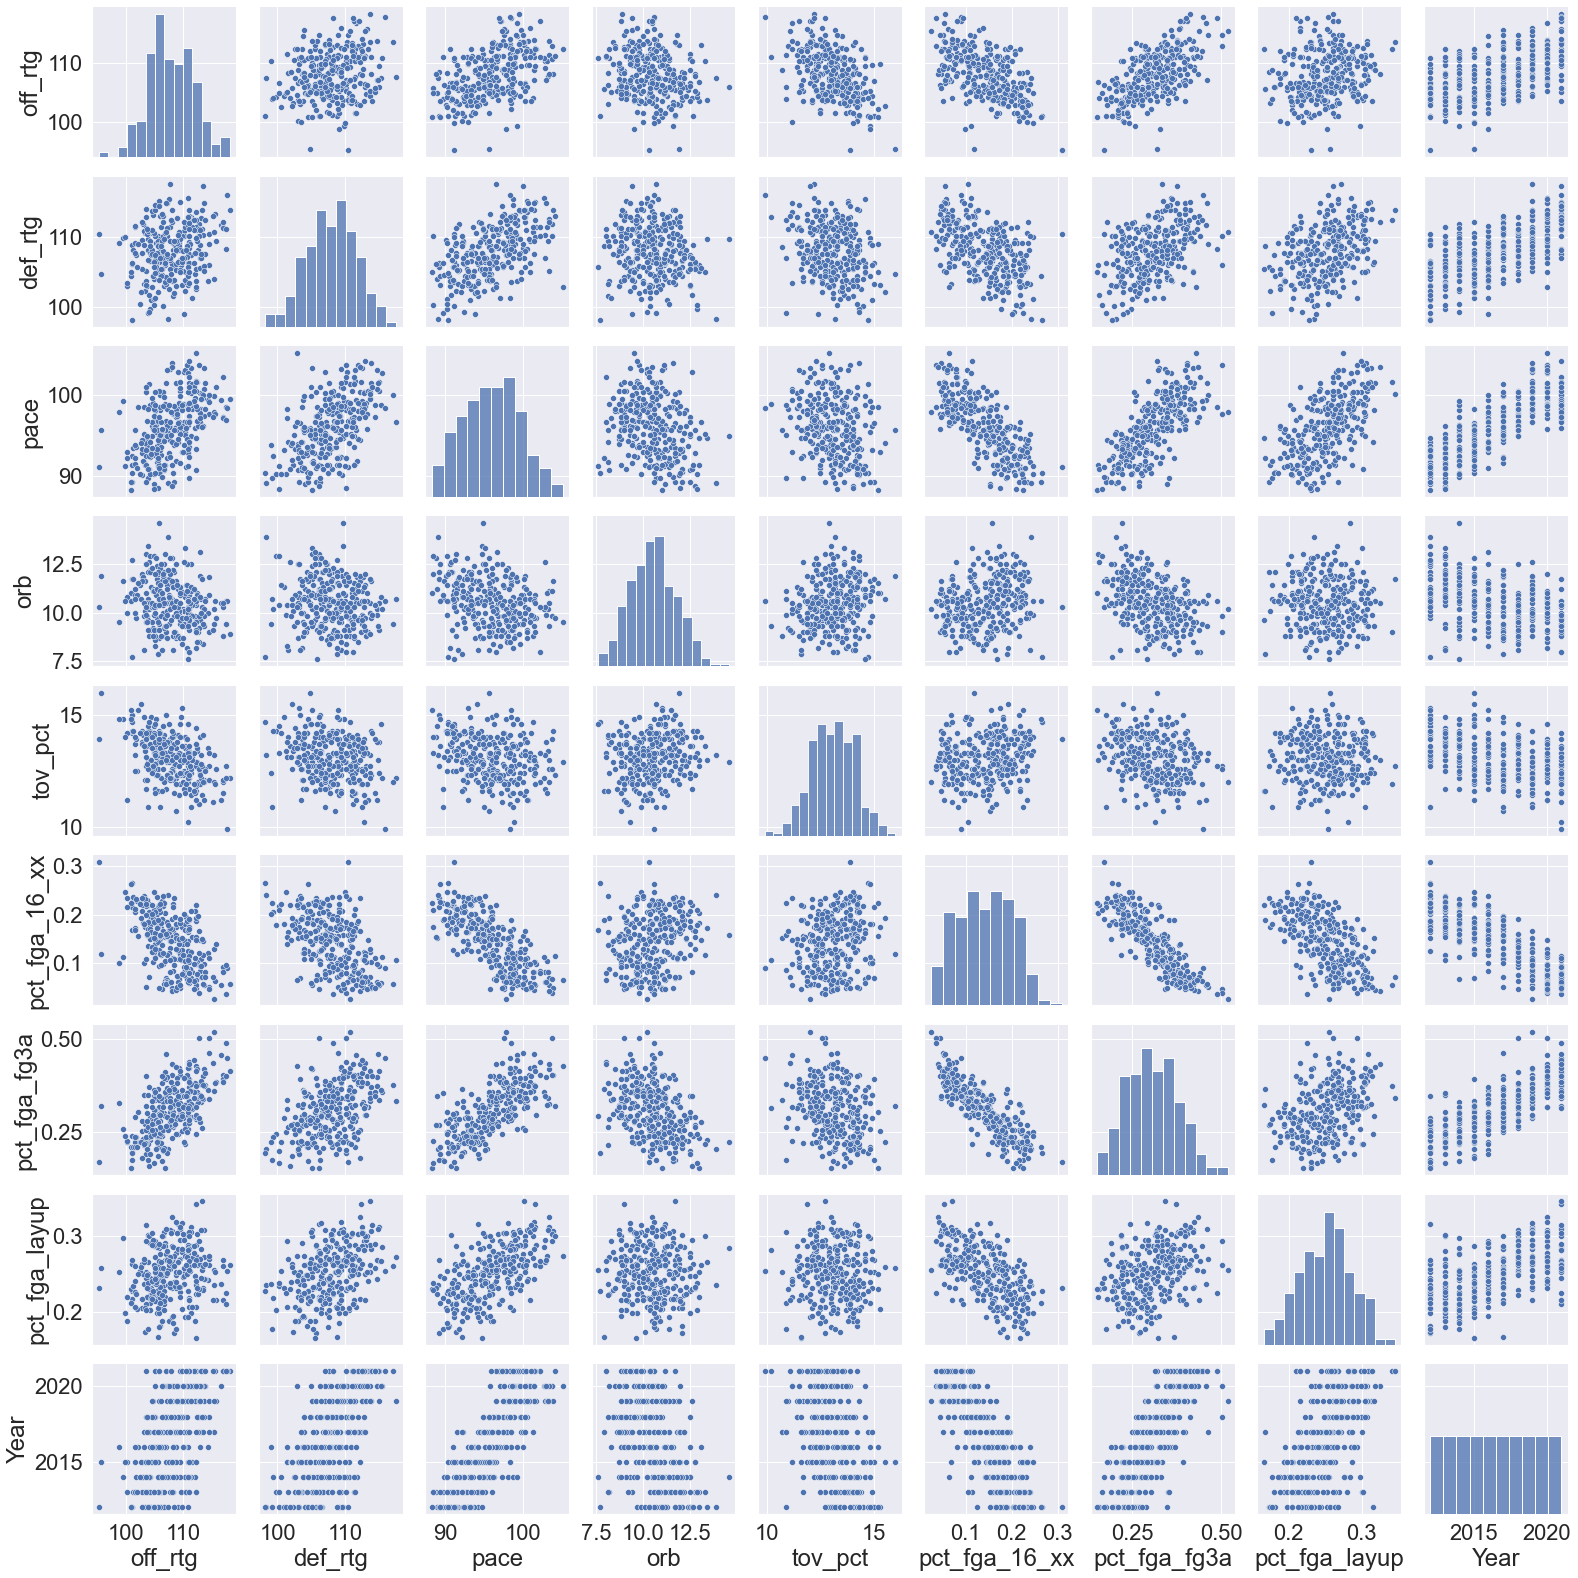

In [270]:
fig=sns.pairplot(all_df_subset)
sns.set(font_scale = 3)

fig.figure.savefig("MVP_pairplot.png")

### Linear regression

In [108]:
import statsmodels.api as sm

In [106]:
diffcolumns=[]
for column in all_df.columns:
    if column.startswith('diff_'):
        diffcolumns.append(column)
diffcolumns

['diff_fg',
 'diff_fga',
 'diff_fg_pct',
 'diff_fg3',
 'diff_fg3a',
 'diff_fg3_pct',
 'diff_fg2',
 'diff_fg2a',
 'diff_fg2_pct',
 'diff_ft',
 'diff_fta',
 'diff_ft_pct',
 'diff_orb',
 'diff_drb',
 'diff_trb',
 'diff_ast',
 'diff_stl',
 'diff_blk',
 'diff_tov',
 'diff_pf',
 'diff_pts',
 'diff_efg_pct_adv',
 'diff_tov_pct_adv',
 'diff_ft_rate_adv',
 'diff_avg_dist',
 'diff_pct_fga_fg2a',
 'diff_pct_fga_00_03',
 'diff_pct_fga_03_10',
 'diff_pct_fga_10_16',
 'diff_pct_fga_16_xx',
 'diff_pct_fga_fg3a',
 'diff_fg_pct_fg2a',
 'diff_fg_pct_00_03',
 'diff_fg_pct_03_10',
 'diff_fg_pct_10_16',
 'diff_fg_pct_16_xx',
 'diff_fg_pct_fg3a',
 'diff_pct_ast_fg2',
 'diff_pct_ast_fg3',
 'diff_pct_fga_dunk',
 'diff_fg_dunk',
 'diff_pct_fga_layup',
 'diff_fg_layup',
 'diff_pct_fg3a_corner',
 'diff_fg3_pct_corner']

In [110]:

x = all_df[diffcolumns]
x = sm.add_constant(x)
y = all_df['net_rtg_adv']
model = sm.OLS(y,x, data = all_df)
car_model = model.fit()
car_model.summary()


C:\Users\Josh_Wang\anaconda3\lib\site-packages\statsmodels\base\model.py:127: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            net_rtg_adv   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.350e+04
Date:                Mon, 14 Feb 2022   Prob (F-statistic):               0.00
Time:                        05:08:40   Log-Likelihood:                 460.15
No. Observations:                 597   AIC:                            -832.3
Df Residuals:                     553   BIC:                            -639.1
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0084      0.005      1.626      0.104      -0.002       0.019
diff_fg                  0.1775      0.109      1.622      0.105      -0.037       0.392
diff_fga                 0.3996      0.078      5.125      0.000       0.246       0.553
diff_fg_pct             42.4338      8.943      4.745      0.000      24.867      60.001
diff_fg3                 0.0009      0.095      0.010      0.992      -0.186       0.187
diff_fg3a                0.2173      0.074      2.955      0.003       0.073       0.362
diff_fg3_pct             1.5511      0.374      4.148      0.000       0.817       2.286
diff_fg2                 0.0895      0.078      1.147      0.252      -0.064       0.243
diff_fg2a                0.1263      0.074      1.696      0.090      -0.020       0.273
diff_fg2_pct            -5.1337      0.970     -5.293      0.000      -7.039      -3.228
diff_ft                  0.2858      0.072      3.991      0.000       0.145       0.426
diff_fta                 0.0285      0.041      0.697      0.486      -0.052       0.109
diff_ft_pct              1.6725      1.263      1.324      0.186      -0.808       4.153
diff_orb                -0.0359      0.068     -0.530      0.596      -0.169       0.097
diff_drb                -0.0368      0.067     -0.550      0.583      -0.168       0.095
diff_trb                 0.0408      0.066      0.614      0.539      -0.090       0.171
diff_ast                 0.0168      0.028      0.597      0.551      -0.038       0.072
diff_stl                -0.0074      0.011     -0.667      0.505      -0.029       0.014
diff_blk                -0.0032      0.008     -0.377      0.706      -0.020       0.013
diff_tov                 0.2931      0.057      5.129      0.000       0.181       0.405
diff_pf                 -0.0028      0.007     -0.369      0.712      -0.017       0.012
diff_pts                 0.4126      0.051      8.108      0.000       0.313       0.513
diff_efg_pct_adv        58.8765      8.377      7.028      0.000      42.422      75.331
diff_tov_pct_adv        -0.3854      0.070     -5.515      0.000      -0.523      -0.248
diff_ft_rate_adv        24.2072      2.984      8.113      0.000      18.346      30.068
diff_avg_dist            0.1030      0.064      1.597      0.111      -0.024       0.230
diff_pct_fga_fg2a      -84.7576    119.427     -0.710      0.478    -319.343     149.828
diff_pct_fga_00_03       7.6300      5.272      1.447      0.148      -2.725      17.985
diff_pct_fga_03_10       7.0279      5.174      1.358      0.175      -3.136      17.192
diff_pct_fga_10_16       6.6420      5.180      1.282      0.200      -3.532      16.816
diff_pct_fga_16_xx       5.1811      5.220      0.993      0.321      -5.072      15.434
diff_pct_fga_fg3a      -74.1864    119.344     -0.622    